In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import sys
import pathlib

sys.path.append(str(pathlib.Path().cwd().parent))

In [45]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [46]:
from plotting import plot_ts

In [47]:
from load_dataset import Dataset
dataset = Dataset('../data/dataset/')

### Предсказание одномерного ряда на одну точку вперед

#### Выгрузим одномерный ряд alcohol_sales 

In [48]:
ts = dataset['alcohol_sales.csv']

/Users/technogleb/ts_march_2023/load_dataset.py:34: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ts = pd.read_csv(


<Axes: xlabel='0'>

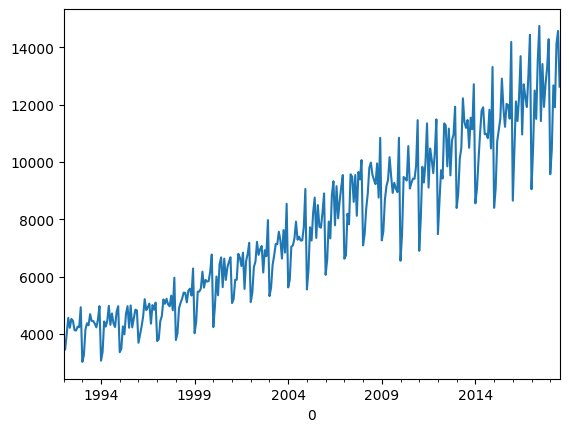

In [49]:
ts.plot()

#### Напишем функцию, которая переводит time series в матрицу обьекты-признаки

In [50]:
def transform_into_matrix(ts: pd.Series, num_lags: int) -> pd.DataFrame:
    """
    Transforms time series into lags matrix to allow
    applying supervised learning algorithms

    Parameters
    ------------
    ts
        Time series to transform
    num_lags
        Number of lags to use

    Returns
    --------
        train, test: np.arrays of shapes (ts-num_lags, num_lags), (num_lags,)
    """

    ts_values = ts.values
    data = {}
    for i in range(num_lags + 1):
        data[f'lag_{num_lags - i}'] = np.roll(ts_values, -i)

    lags_matrix = pd.DataFrame(data)[:-num_lags]
    lags_matrix.index = ts.index[num_lags:]

    return lags_matrix.drop('lag_0', axis=1).values, lags_matrix['lag_0'].values

In [51]:
NUM_LAGS = 24
X, y = transform_into_matrix(ts, NUM_LAGS)

#### Сделаем необходимый reshape к двумерному виду для сверточного слоя и разобьем на train, test 

In [52]:
X = X.reshape((X.shape[0], X.shape[1], 1))

split_idx = int(len(ts) * 0.7)
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

In [53]:
X[0]

array([[3459],
       [3458],
       [4002],
       [4564],
       [4221],
       [4529],
       [4466],
       [4137],
       [4126],
       [4259],
       [4240],
       [4936],
       [3031],
       [3261],
       [4160],
       [4377],
       [4307],
       [4696],
       [4458],
       [4457],
       [4364],
       [4236],
       [4500],
       [4974]])

In [54]:
y[0]

3075

#### Зададим входной сверточный слой модели.

In [55]:
model = Sequential()

In [56]:
### Обратим внимание на то, что для временных рядов используется свертка только в одном направлении по временной
### шкале - поэтому Conv1D
model.add(Conv1D(64, 2, activation='relu', input_shape=(NUM_LAGS, 1)))

#### Добавим Pooling для борьбы с переобучением (наличие/отсутствие пулинга как и выбор его типа опционален и зависит от длины вашего ряда, сложности паттерна и т.д., что влияет на переобучение вашей модели) 

In [57]:
model.add(MaxPooling1D())

#### Добавим слой Flatten для перехода к одномерному формату входных данных для полносвязной сети

In [58]:
model.add(Flatten())

#### Добавим пару промежуточных полносвязных слоев и выходной слой с одним нейроном для предсказания одной точки

In [59]:
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))

In [60]:
model.compile(optimizer='adam', loss='mse')

In [61]:
model.fit(X_train, y_train, epochs=400, verbose=1, validation_data=(X_test, y_test))

Epoch 1/400
7/7 [==============================] - 0s 12ms/step - loss: 15108305.0000 - val_loss: 2160146.5000
Epoch 2/400
7/7 [==============================] - 0s 3ms/step - loss: 3465672.5000 - val_loss: 6670916.0000
Epoch 3/400
7/7 [==============================] - 0s 3ms/step - loss: 1081579.8750 - val_loss: 3037365.7500
Epoch 4/400
7/7 [==============================] - 0s 3ms/step - loss: 1367905.8750 - val_loss: 2273711.2500
Epoch 5/400
7/7 [==============================] - 0s 3ms/step - loss: 715519.3125 - val_loss: 2204134.2500
Epoch 6/400
7/7 [==============================] - 0s 3ms/step - loss: 764574.6250 - val_loss: 1576878.3750
Epoch 7/400
7/7 [==============================] - 0s 3ms/step - loss: 579270.5000 - val_loss: 1523393.5000
Epoch 8/400
7/7 [==============================] - 0s 3ms/step - loss: 577012.8125 - val_loss: 1364150.6250
Epoch 9/400
7/7 [==============================] - 0s 3ms/step - loss: 523627.0625 - val_loss: 1359553.5000
Epoch 10/400
7/7 [====

Epoch 77/400
7/7 [==============================] - 0s 3ms/step - loss: 119123.9922 - val_loss: 298631.8750
Epoch 78/400
7/7 [==============================] - 0s 3ms/step - loss: 114671.9844 - val_loss: 321813.0625
Epoch 79/400
7/7 [==============================] - 0s 3ms/step - loss: 112897.5000 - val_loss: 281864.3125
Epoch 80/400
7/7 [==============================] - 0s 3ms/step - loss: 114654.3281 - val_loss: 297442.7188
Epoch 81/400
7/7 [==============================] - 0s 3ms/step - loss: 107147.9609 - val_loss: 269828.6250
Epoch 82/400
7/7 [==============================] - 0s 3ms/step - loss: 111227.5000 - val_loss: 309789.1250
Epoch 83/400
7/7 [==============================] - 0s 3ms/step - loss: 108358.1406 - val_loss: 277340.0000
Epoch 84/400
7/7 [==============================] - 0s 3ms/step - loss: 107285.5625 - val_loss: 285017.5938
Epoch 85/400
7/7 [==============================] - 0s 3ms/step - loss: 107948.7109 - val_loss: 319773.0938
Epoch 86/400
7/7 [==========

7/7 [==============================] - 0s 3ms/step - loss: 88818.2422 - val_loss: 262304.9688
Epoch 153/400
7/7 [==============================] - 0s 3ms/step - loss: 90976.4609 - val_loss: 236909.9688
Epoch 154/400
7/7 [==============================] - 0s 3ms/step - loss: 85237.1328 - val_loss: 206060.5000
Epoch 155/400
7/7 [==============================] - 0s 3ms/step - loss: 85599.3906 - val_loss: 203912.3594
Epoch 156/400
7/7 [==============================] - 0s 3ms/step - loss: 93873.7344 - val_loss: 205137.2656
Epoch 157/400
7/7 [==============================] - 0s 3ms/step - loss: 99771.5078 - val_loss: 219577.8438
Epoch 158/400
7/7 [==============================] - 0s 3ms/step - loss: 123620.2578 - val_loss: 493797.7812
Epoch 159/400
7/7 [==============================] - 0s 3ms/step - loss: 116371.6562 - val_loss: 374071.6562
Epoch 160/400
7/7 [==============================] - 0s 3ms/step - loss: 111227.3594 - val_loss: 207839.5156
Epoch 161/400
7/7 [====================

Epoch 228/400
7/7 [==============================] - 0s 3ms/step - loss: 75414.3281 - val_loss: 172079.7344
Epoch 229/400
7/7 [==============================] - 0s 3ms/step - loss: 75038.7734 - val_loss: 186428.2969
Epoch 230/400
7/7 [==============================] - 0s 3ms/step - loss: 71624.1094 - val_loss: 246864.8906
Epoch 231/400
7/7 [==============================] - 0s 3ms/step - loss: 77049.2891 - val_loss: 290975.5000
Epoch 232/400
7/7 [==============================] - 0s 3ms/step - loss: 80760.3984 - val_loss: 171908.0000
Epoch 233/400
7/7 [==============================] - 0s 3ms/step - loss: 75479.9922 - val_loss: 166906.1719
Epoch 234/400
7/7 [==============================] - 0s 3ms/step - loss: 83675.3750 - val_loss: 168191.4219
Epoch 235/400
7/7 [==============================] - 0s 3ms/step - loss: 78386.0703 - val_loss: 213345.9531
Epoch 236/400
7/7 [==============================] - 0s 3ms/step - loss: 72142.0234 - val_loss: 183580.3438
Epoch 237/400
7/7 [=========

Epoch 304/400
7/7 [==============================] - 0s 3ms/step - loss: 73011.0703 - val_loss: 152225.6094
Epoch 305/400
7/7 [==============================] - 0s 3ms/step - loss: 69535.1953 - val_loss: 153990.3750
Epoch 306/400
7/7 [==============================] - 0s 3ms/step - loss: 74325.8125 - val_loss: 192783.9688
Epoch 307/400
7/7 [==============================] - 0s 3ms/step - loss: 85989.6953 - val_loss: 267795.2812
Epoch 308/400
7/7 [==============================] - 0s 3ms/step - loss: 72242.8984 - val_loss: 170113.1406
Epoch 309/400
7/7 [==============================] - 0s 3ms/step - loss: 66722.0859 - val_loss: 206162.7812
Epoch 310/400
7/7 [==============================] - 0s 3ms/step - loss: 66787.7969 - val_loss: 162845.4062
Epoch 311/400
7/7 [==============================] - 0s 3ms/step - loss: 63191.8477 - val_loss: 153978.3906
Epoch 312/400
7/7 [==============================] - 0s 3ms/step - loss: 62339.5938 - val_loss: 200521.8750
Epoch 313/400
7/7 [=========

Epoch 380/400
7/7 [==============================] - 0s 3ms/step - loss: 69486.7969 - val_loss: 166659.0625
Epoch 381/400
7/7 [==============================] - 0s 3ms/step - loss: 67733.4453 - val_loss: 192782.9844
Epoch 382/400
7/7 [==============================] - 0s 3ms/step - loss: 75924.7109 - val_loss: 300653.9062
Epoch 383/400
7/7 [==============================] - 0s 3ms/step - loss: 75445.4062 - val_loss: 238531.0000
Epoch 384/400
7/7 [==============================] - 0s 3ms/step - loss: 63938.3555 - val_loss: 150597.4062
Epoch 385/400
7/7 [==============================] - 0s 3ms/step - loss: 56464.0352 - val_loss: 147273.4688
Epoch 386/400
7/7 [==============================] - 0s 3ms/step - loss: 64823.8516 - val_loss: 147537.6875
Epoch 387/400
7/7 [==============================] - 0s 3ms/step - loss: 66068.2188 - val_loss: 158858.6250
Epoch 388/400
7/7 [==============================] - 0s 3ms/step - loss: 63027.8164 - val_loss: 191251.7656
Epoch 389/400
7/7 [=========

In [62]:
y_pred = model.predict(X_test).flatten()

3/3 [==============================] - 0s 783us/step


<Axes: >

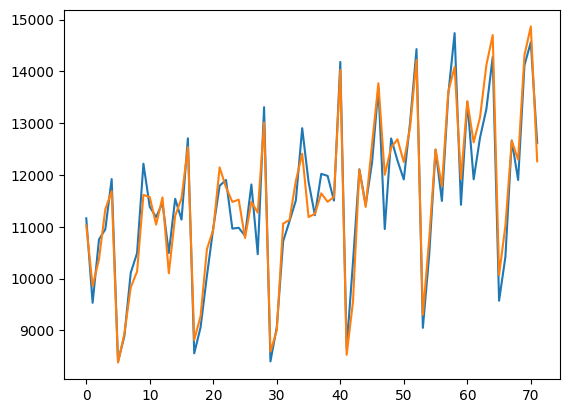

In [63]:
pd.Series(y_test).plot()
pd.Series(y_pred).plot()

### Векторное предсказание для одномерного ряда

Попробуем решить аналогичную предыдущему занятию задачу предсказания вектора следующих точек, но теперь добавим
в модель признаки, сгенерённые сверточным слоем 

#### 1) Возьмем функцию трансформации ряда из прошлого занятия

In [80]:
from typing import Tuple

def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    """
    Данная функция должна пройтись скользящим окном по временному ряду и для каждых
    num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.
    
    Вернуть два np.array массива из X_train и y_train соответственно
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    outer_idx = num_lags_out
    while outer_idx < len(sequence):
        inner_idx = i + num_lags_in
        outer_idx = inner_idx + num_lags_out
        X_, y_ = sequence[i:inner_idx], sequence[inner_idx:outer_idx]
        X.append(X_)
        y.append(y_)
        i += 1
    return np.array(X), np.array(y)

#### 2) Приведем входные данные к двумерному виду

In [81]:
NUM_LAGS = 24
NUM_OUTPUT = 12
X, y = transform_ts_into_matrix(ts, NUM_LAGS, NUM_OUTPUT)
X = X.reshape((X.shape[0], X.shape[1], 1))

#### 3) Разобьем на трейн и тест, отложив в качестве теста последние 12 точек

In [82]:
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[[-1]], y[-1]

In [83]:
X_train.shape

(283, 24, 1)

In [95]:
y_train.shape

(283, 12)

In [98]:
y_test = y_test.reshape((1, 12))

#### 4) Постройте сеть из CNN слоев, соединенных с полносвязными слоями 

In [99]:
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(NUM_LAGS, 1)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(NUM_OUTPUT))
model.compile(optimizer='adam', loss='mse')

#### 5) Обучите модель

In [102]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
9/9 [==============================] - 0s 9ms/step - loss: 388980.0938 - val_loss: 848108.0000
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 382627.4062 - val_loss: 851043.0000
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 376513.6875 - val_loss: 861994.9375
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 373148.8750 - val_loss: 778916.1875
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 371672.1562 - val_loss: 836320.8125
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 370829.7812 - val_loss: 829583.5000
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 366041.3438 - val_loss: 795197.2500
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 364802.1562 - val_loss: 772758.6875
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 362771.4062 - val_loss: 811406.0000
Epoch 10/100
9/9 [===================

Epoch 77/100
9/9 [==============================] - 0s 2ms/step - loss: 227104.6719 - val_loss: 301415.4062
Epoch 78/100
9/9 [==============================] - 0s 2ms/step - loss: 225756.9688 - val_loss: 398811.2500
Epoch 79/100
9/9 [==============================] - 0s 2ms/step - loss: 224601.3594 - val_loss: 467774.1562
Epoch 80/100
9/9 [==============================] - 0s 2ms/step - loss: 222734.0312 - val_loss: 356138.5938
Epoch 81/100
9/9 [==============================] - 0s 2ms/step - loss: 223933.7500 - val_loss: 401182.4062
Epoch 82/100
9/9 [==============================] - 0s 2ms/step - loss: 220836.7031 - val_loss: 347038.6875
Epoch 83/100
9/9 [==============================] - 0s 2ms/step - loss: 217639.1406 - val_loss: 320229.8125
Epoch 84/100
9/9 [==============================] - 0s 2ms/step - loss: 221878.8906 - val_loss: 371108.6562
Epoch 85/100
9/9 [==============================] - 0s 2ms/step - loss: 214047.6250 - val_loss: 394992.4062
Epoch 86/100
9/9 [==========

#### 5) Постройте предсказания (не забудьте вызвать метод flatten в конце предсказания)

In [103]:
y_pred = model.predict(X_test).flatten()

1/1 [==============================] - 0s 27ms/step


<Axes: >

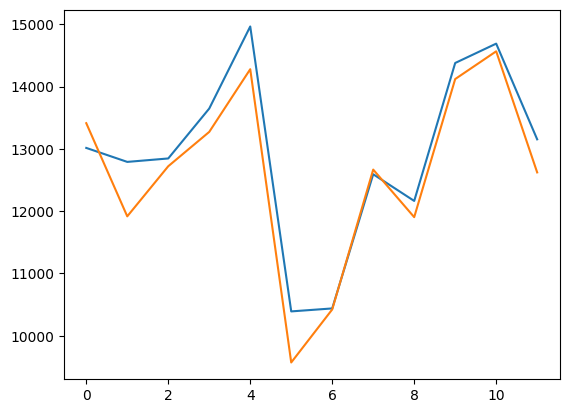

In [107]:
pd.Series(y_pred).plot()
pd.Series(y_test.flatten()).plot()

In [111]:
from sklearn.metrics import mean_absolute_error

#### 6) Постройте предсказание без добавления сверточных слоев и сравните качество

In [114]:
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(NUM_LAGS, 1)))
model.add(MaxPooling1D())
model.add(Dense(64))
model.add(Dense(32))
model.add(Flatten())
model.add(Dense(NUM_OUTPUT))
model.compile(optimizer='adam', loss='mse')

In [115]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
9/9 [==============================] - 1s 11ms/step - loss: 47850608.0000 - val_loss: 28346434.0000
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 6142364.0000 - val_loss: 19660656.0000
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 3360478.2500 - val_loss: 4699874.0000
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 2502600.5000 - val_loss: 1925206.6250
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 1381477.8750 - val_loss: 3762864.0000
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 1166308.6250 - val_loss: 2281901.0000
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 1103624.2500 - val_loss: 2534002.7500
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 1060367.3750 - val_loss: 2112666.7500
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 1034631.3750 - val_loss: 2137924.7500
Epoch 10/100
9/

9/9 [==============================] - 0s 2ms/step - loss: 412354.5938 - val_loss: 642941.7500
Epoch 77/100
9/9 [==============================] - 0s 2ms/step - loss: 393378.8750 - val_loss: 683138.4375
Epoch 78/100
9/9 [==============================] - 0s 2ms/step - loss: 401803.4688 - val_loss: 740697.6875
Epoch 79/100
9/9 [==============================] - 0s 2ms/step - loss: 390305.3438 - val_loss: 928827.8125
Epoch 80/100
9/9 [==============================] - 0s 2ms/step - loss: 380012.2188 - val_loss: 973184.0625
Epoch 81/100
9/9 [==============================] - 0s 3ms/step - loss: 371258.1250 - val_loss: 585259.6250
Epoch 82/100
9/9 [==============================] - 0s 3ms/step - loss: 357260.1875 - val_loss: 940954.8125
Epoch 83/100
9/9 [==============================] - 0s 3ms/step - loss: 349178.2188 - val_loss: 851415.1875
Epoch 84/100
9/9 [==============================] - 0s 3ms/step - loss: 341155.8750 - val_loss: 599486.1250
Epoch 85/100
9/9 [=======================

In [116]:
y_pred = model.predict(X_test).flatten()

1/1 [==============================] - 0s 53ms/step


In [117]:
y_test

array([[13412, 11917, 12721, 13272, 14278,  9572, 10423, 12667, 11904,
        14120, 14565, 12622]])

<Axes: >

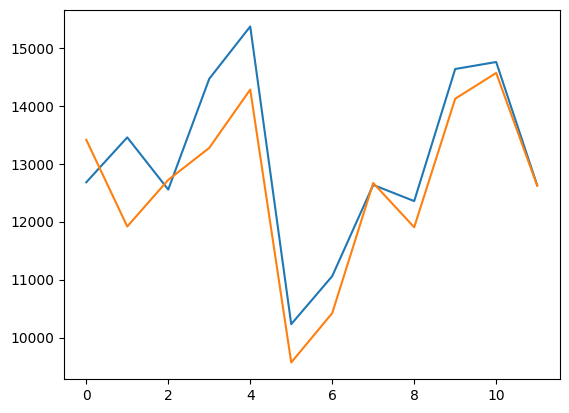

In [119]:
pd.Series(y_pred).plot()
pd.Series(y_test.flatten()).plot()

In [45]:
mean_absolute_error(y_test ,y_pred)

500.0393880208333

### Предсказание многомерного ряда

Где применение CNN вызывает наибольший интерес, так это в многомерных рядах или рядах с наличием экзогенных признаков, так как позволяет автоматически генерировать большое количество признаков из коррелирующих рядов.

В данном примере мы будем предсказывать каждую компоненту многомерного временного ряда, используя данные из всех компонент, т.е. каждая компонента будет в качестве признаков лаги всех соседних рядов, а CNN будет вычленять из них произвольные признаки.

In [120]:
ts = pd.read_csv('../data/stability_index.csv', index_col='timestamp', parse_dates=True)

In [121]:
ts.head()

,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,
2020-01-15 13:00:00,205.0,92.0,63.0,55.0,26.0,27.0,20.0,34.0,155.0
2020-01-15 14:00:00,173.0,97.0,69.0,44.0,31.0,22.0,41.0,26.0,182.0
2020-01-15 15:00:00,145.0,83.0,73.0,58.0,40.0,25.0,31.0,19.0,167.0
2020-01-15 16:00:00,84.0,60.0,53.0,39.0,32.0,31.0,19.0,15.0,102.0
2020-01-15 17:00:00,117.0,77.0,40.0,53.0,33.0,29.0,21.0,30.0,160.0


<Axes: xlabel='timestamp'>

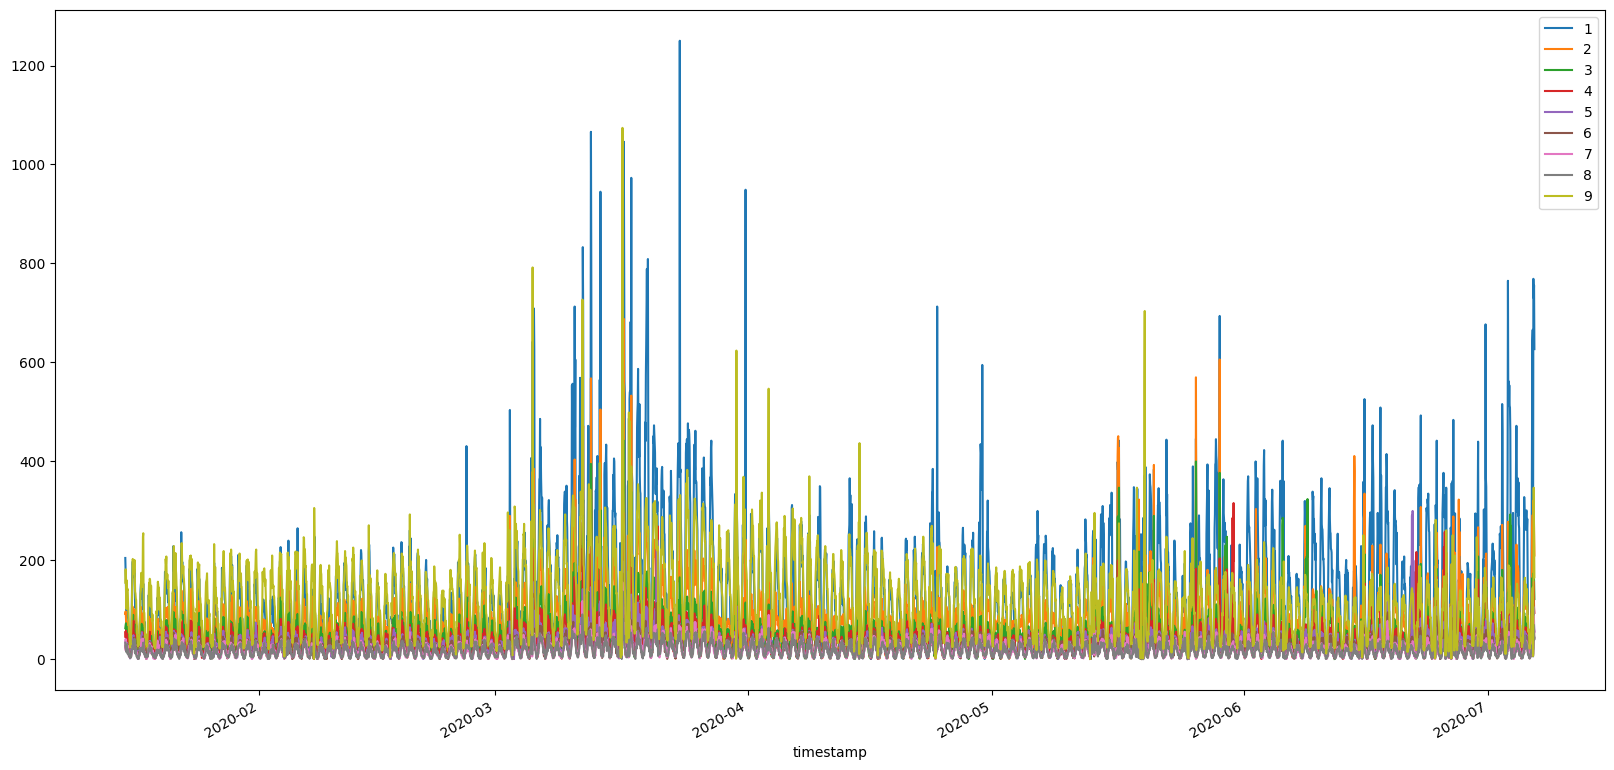

In [122]:
ts.plot(figsize=(20, 10))

In [123]:
import math

from pandas._libs.tslibs.timestamps import Timestamp


def get_month_sin(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.sin(theta)


def get_month_cos(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.cos(theta)


def get_day_sin(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.sin(theta)


def get_day_cos(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.cos(theta)


def get_dayofweek_sin(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.sin(theta)


def get_dayofweek_cos(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.cos(theta)


def get_hour_sin(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.sin(theta)


def get_hour_cos(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.cos(theta)


def get_minute_sin(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.sin(theta)


def get_minute_cos(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.cos(theta)


datetime_mappers = {
    'month_sin': get_month_sin,
    'month_cos': get_month_cos,
    'day_sin': get_day_sin,
    'day_cos': get_day_cos,
    'dayofweek_sin': get_dayofweek_sin,
    'dayofweek_cos': get_dayofweek_cos,
    'hour_sin': get_hour_sin,
    'hour_cos': get_hour_cos,
    'minute_sin': get_minute_sin,
    'minute_cos': get_minute_cos,
}

In [124]:
ts.fillna(ts.median(), inplace=True)

#### 1) Возьмем функцию из предыдущего занятия (исключая метод flaten в конце, так как CNN принимает как раз 2D данные)

In [160]:
def transform_multi_ts_into_matrix(ts: pd.DataFrame, num_lags: int):
    """
    Данная функция должна пройтись скользящим окном по временному ряду
    и собрать в качестве признаков X np.array размерности (len(ts)-num_lags, n_dims, num_lags),
    а в качестве y np.array размерности (len(ts)-num_lags, n_dims),
    где n_dims - размерность многомерного ряда.
    
    То есть для всех компонент временного ряда мы должны взять num_lags предыдущих точек каждой компонент
    в качестве признаков и все компоненты текущей точки в качестве target
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    end_i = num_lags
    while end_i < len(sequence): 
        seq_x, seq_y = sequence[i:end_i], sequence[end_i]
        X.append(seq_x.T)
        y.append(seq_y)
        i += 1
        end_i = i + num_lags
    return np.array(X), np.array(y)

In [161]:
NUM_LAGS = 14
NUM_DIMS = ts.shape[1]

In [162]:
X, y = transform_multi_ts_into_matrix(ts, NUM_LAGS)

In [163]:
# Видим, что в качестве обьекта мы получаем матрицу, где количество строк равно количеству компонент нашего ряда
# а количество столбцов количеству лагов, которое мы берем для каждой из компонент
X[0].shape

(9, 14)

In [129]:
y[0].shape

(9,)

In [147]:
X = X.reshape((4131, 14, 9))

In [148]:
X.shape

(4131, 14, 9)

#### 2) Разбейте на train/test

In [164]:
X_train, y_train = X[:-24], y[:-24]
X_test, y_test = X[-24:], y[-24:]

#### 3) Постройте сеть, со сверточным слоем и несколькими полносвязными в конце (подумайте какой shape входных и выходных данных должен быть у первого и последнего слоя)

In [169]:
model = Sequential()
model.add(Conv1D(32, 6, activation='relu', input_shape=(9, 14)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(9))
model.compile(optimizer='adam', loss='mse')


#### 4) Обучите модель

In [170]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
129/129 [==============================] - 1s 1ms/step - loss: 2538.4902 - val_loss: 6324.2812
Epoch 2/100
129/129 [==============================] - 0s 595us/step - loss: 1241.5986 - val_loss: 5686.1792
Epoch 3/100
129/129 [==============================] - 0s 618us/step - loss: 1112.3120 - val_loss: 5334.0171
Epoch 4/100
129/129 [==============================] - 0s 621us/step - loss: 1053.5143 - val_loss: 5308.3936
Epoch 5/100
129/129 [==============================] - 0s 638us/step - loss: 1011.6271 - val_loss: 5162.4478
Epoch 6/100
129/129 [==============================] - 0s 616us/step - loss: 1005.8132 - val_loss: 4995.4380
Epoch 7/100
129/129 [==============================] - 0s 665us/step - loss: 973.7568 - val_loss: 4961.2056
Epoch 8/100
129/129 [==============================] - 0s 634us/step - loss: 951.0814 - val_loss: 4914.7485
Epoch 9/100
129/129 [==============================] - 0s 641us/step - loss: 936.4871 - val_loss: 4970.2085
Epoch 10/100
129/129 [==

129/129 [==============================] - 0s 670us/step - loss: 577.1927 - val_loss: 3646.9590
Epoch 77/100
129/129 [==============================] - 0s 628us/step - loss: 570.6132 - val_loss: 3884.7180
Epoch 78/100
129/129 [==============================] - 0s 706us/step - loss: 571.1621 - val_loss: 3776.8328
Epoch 79/100
129/129 [==============================] - 0s 715us/step - loss: 567.7524 - val_loss: 3702.3867
Epoch 80/100
129/129 [==============================] - 0s 715us/step - loss: 574.1722 - val_loss: 3839.2441
Epoch 81/100
129/129 [==============================] - 0s 721us/step - loss: 559.8588 - val_loss: 3884.0159
Epoch 82/100
129/129 [==============================] - 0s 730us/step - loss: 557.2039 - val_loss: 3610.0518
Epoch 83/100
129/129 [==============================] - 0s 700us/step - loss: 558.9835 - val_loss: 3935.4153
Epoch 84/100
129/129 [==============================] - 0s 698us/step - loss: 557.3011 - val_loss: 3748.3157
Epoch 85/100
129/129 [==========

#### 5) Сделайте предсказание на тесте

In [171]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 28ms/step


<Axes: >

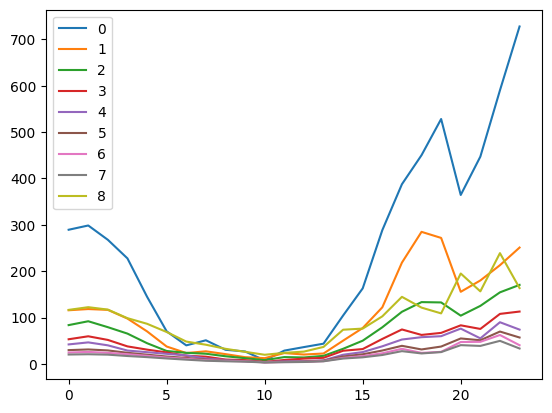

In [172]:
pd.DataFrame(y_pred).plot()

<Axes: >

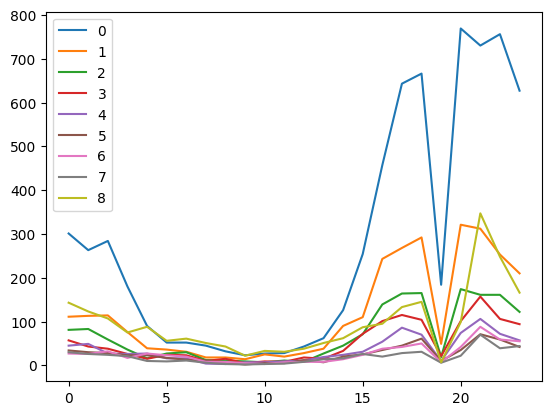

In [173]:
pd.DataFrame(y_test).plot()

In [174]:
X_train, y_train = X[:-24], y[:-24]
X_test, y_test = X[-24:], y[-24:]

#### 6) Сравните полученые предсказания с предсказанием каждой компоненты как отдельного ряда при помощи TimeSeriesPredictor

* Разбейте ряд на 9 одномерных рядов
* Обучите модель TimeSeriesPredictor
* Сделайте батч предсказание на длину X_test
* сравните результаты с CNN

In [136]:
def train_test_split(ts: pd.Series, ratio: float = 0.7) -> Tuple[pd.Series]:
    split_idx = 24
    ts_train, ts_test = ts[:-split_idx], ts[-split_idx:]
    # ваш код здесь
    return ts_train, ts_test

In [125]:
def make_pipeline(
    ts: pd.Series,
    granularity: str,
    model: callable,
    num_lags=24,
    use_mappers=True,
    **kwargs
) -> Tuple[pd.Series]:
    
    train, test = train_test_split(ts)
    
    predictor = TimeSeriesPredictor(
        granularity=granularity,
        num_lags=num_lags,
        model=model,
    )
    
    if use_mappers:
        predictor.set_params(mappers=datetime_mappers)
        
    predictor.set_params(**kwargs)
    predictor.fit(train)
    
    in_sample = predictor.predict_batch(train, test)
    out_of_sample = predictor.predict_next(train, len(test))
    
   
    out_of_sample.index = test.index
    
    return train, test, in_sample, out_of_sample

In [104]:
X_train[0].shape# ваш код здесь

(9, 14)

In [105]:
y_train[0].shape

(9,)

In [81]:
y_train.shape

(260, 12)

In [80]:
y_train.reshape(-1,1).shape

(3120, 1)

In [113]:
y_train

array([[ 23.,  13.,  13., ...,   5.,   3.,  24.],
       [ 19.,   9.,   7., ...,   3.,   3.,  32.],
       [ 22.,  18.,   5., ...,   4.,   5.,  31.],
       ...,
       [262., 116.,  68., ...,  23.,  22., 152.],
       [284., 102.,  62., ...,  32.,  22., 145.],
       [301., 108.,  75., ...,  38.,  34., 110.]])

In [114]:
ts_0= []
for i in range(len(y_train)):
    ts_0.append(y_train[i][0])
    

In [118]:
len(ts_0)

4107

In [126]:
ts_0 = pd.Series(ts_0, index = ts[:-38].index)

In [128]:
from model import TimeSeriesPredictor

In [134]:
ts_0.fillna(0,inplace=True)

In [139]:
from sklearn.linear_model import LinearRegression
ts = ts_0
granularity = 'PT1H'
model = LinearRegression
num_lags = 24
params = {}
train, test, in_sample, out_of_sample = make_pipeline(ts_0, granularity, model, num_lags, use_mappers=True, **params)

In [140]:
plot_ts(train, test, out_of_sample)

Loading BokehJS ...

#### 7) Сделайте то же самое, что и в 6 пункте, но теперь добавьте в качестве признаков для каждого одномерного ряда лаги от всех остальных 8 рядов. Получился ли результат лучше чем CNN?

In [43]:
# ваш код здесь